In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src')) # include top level package in python path

In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
.container { 
    width: 100% !important;
}
</style>
"""))

In [3]:
import torch
from torch import nn, Tensor
from model.fuzzy_logic import ProductLogic, MinimumLogic, LukasiewiczLogic, DrasticLogic, SchweizerSklarLogic
from model.fuzzy_layer import FuzzyMLP, FuzzyParam
from model.bool_logic import BoolLogic
from cache import TestMetric, TrainingRegime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = 'cuda'

logic = BoolLogic()
flogic = ProductLogic()

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

trainset = datasets.MNIST(root='./_mnist', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./_mnist', train=False, download=True, transform=transforms.ToTensor())

trainloader = DataLoader(trainset, batch_size=128)
testloader = DataLoader(testset, batch_size=128)

In [5]:
class CorrectOutputMetric(TestMetric):
    def name(self):
        return "correct-output"
    
    def measure_model(self, model, it):
        correct_count = 0
        total_count = 0

        with torch.no_grad():
            for imgs, labels in it():
                preds = model(imgs.to(device))
                if hasattr(model.__class__, "zero_reg"):
                    model.zero_reg()
                pred_labels = preds.argmax(dim=-1)
                correct_count += (pred_labels == labels.to(device)).sum()
                total_count += labels.numel()

        return (correct_count / total_count).item()
    
class LogicCorrectOutputMetric(TestMetric):
    def name(self):
        return "logic-correct-output"

    def measure_model(self, model, it):
        correct_count = 0
        total_count = 0
        
        with torch.no_grad():
            for imgs, labels in it():
                preds = model.fuzzy_forward(imgs.to(device))
                if hasattr(model.__class__, "zero_reg"):
                    model.zero_reg()
                pred_labels = preds.argmax(dim=-1)
                correct_count += (pred_labels == labels.to(device)).sum()
                total_count += labels.numel()

        return (correct_count / total_count).item()
    
class UnsatisfiedMetric(TestMetric):
    def name(self):
        return "unsatisfied"

    def measure_model(self, model, it):
        total = 0
        
        for imgs, _ in it():
            total += model.from_all_layers(
                imgs.to(device),
                lambda lyr, inp, outp: (
                    1 - lyr.satisfactions(inp, outp)
                ).sum()
            )

        return total.item()
    
class ExampleMetric(TestMetric):
    def name(self):
        return "examples"

    def measure_model(self, model, it):
        total = 0
        
        for imgs, _ in it():
            total += model.from_all_layers(
                imgs.to(device),
                lambda lyr, inp, outp: (
                    lyr.examples(inp, outp)
                ).sum()
            )

        return total.item()
    
class CrispnessMetric(TestMetric):
    def name(self):
        return "crispness"

    def measure_model(self, model, it):
        total = 0
        
        for imgs, _ in it():
            total += model.from_all_layers(
                imgs.to(device),
                lambda lyr, inp, outp: (
                    lyr.crispness()
                ).sum()
            )

        return total.item()

In [6]:
exp = 2

class FuzzyMNIST(nn.Module):
    
    def __init__(self, logic, layers: tuple[tuple[int,...],...], clauses_per_output: int, signed_clauses: bool, joint: bool):
        super().__init__()
        self.logic = logic
        self.clauses_per_output = clauses_per_output
        self.signed_clauses = signed_clauses
        self.joint = joint
        
        self.layers = nn.ModuleList([
            FuzzyMLP(logic, shape, clauses_per_output, signed_clauses) for shape in layers
        ])
        
        self.logic_loss = nn.CrossEntropyLoss()
        
        #self.reg = None
        #self.pos = None
        #self.crisp = None
        self.diff = None
        
    def forward(self, input):
        prev_output = input.flatten(start_dim=1)
        #self.reg = torch.tensor(0.0, device=input.device)
        #self.pos = torch.tensor(0.0, device=input.device)
        #self.crisp = torch.tensor(0.0, device=input.device)
        self.diff = torch.tensor(0.0, device=input.device)
        for idx, layer in enumerate(self.layers):
            output = layer(prev_output)
            if idx > 0:
                #exs = layer.satisfactions(prev_output, output)
                #self.reg += ((1 - exs) ** exp).sum()
                #pos_exs = layer.examples(prev_output, output)
                #self.pos += (pos_exs ** exp).sum()
                #crisp_exs = layer.crispness()
                #self.crisp += (crisp_exs ** 1).sum()
                #if self.maxsat:
                #    precs = layer.preconditions(prev_output.detach())
                #    self.diff += (self.logic.implies(precs, output.unsqueeze(-1).detach()) ** exp).sum()
                #    self.diff += 10 * (self.logic.bin_conjoin(precs, output.unsqueeze(-1).detach()) ** exp).sum()
                #else:
                #    preds = layer.logic_preds(prev_output.detach())
                #    self.diff += (self.logic.implies(preds, output.detach()) ** exp).sum()
                #    self.diff += 10 * (self.logic.bin_conjoin(preds, output.detach()) ** exp).sum()
                before = prev_output
                after = output
                if not self.joint:
                    before = before.detach()
                    after = after.detach()
                preds = layer.logic_preds(before)
                output_probs = torch.softmax(after, dim=-1)
                self.diff += self.logic_loss(preds, output_probs)
            prev_output = output
            
        return torch.softmax(prev_output, dim=-1)
    
    def fuzzy_forward(self, input):
        prev_output = input.flatten(start_dim=1)
        for idx, layer in enumerate(self.layers):
            if idx > 0:
                output = layer.logic_preds(prev_output)
            else:
                output = layer(prev_output)
            prev_output = output
            
        return torch.softmax(prev_output, dim=-1)
    
    def from_all_layers(self, input, f):
        total = torch.tensor(0.0, device=input.device)
        
        with torch.no_grad():
            prev_output = input.flatten(start_dim=1)
            for idx, layer in enumerate(self.layers):
                output = layer(prev_output)
                if idx > 0:
                    total += f(layer, prev_output, output).sum()
                prev_output = output
                
        return total
    
    def logic_reg(self):
        return self.reg
    
    def pos_reg(self):
        return self.pos
    
    def crisp_reg(self):
        return self.crisp
    
    def diff_reg(self):
        return self.diff
    
    def zero_reg(self):
        #self.reg = None
        #self.pos = None
        #self.crisp = None
        self.diff = None

In [11]:
class MNISTRealRegime(TrainingRegime):
    def __init__(
        self, 
        logic, 
        layers, 
        clauses_per_output,
        diff_weight,
        joint,
        l2_reg,
        #maxsat,
        #signed_clauses, 
        #reg_weight, 
        #pos_weight, 
        #crisp_weight, 
        lr=1e-2, 
        no_runs=1
    ):
        super().__init__("./mnist/", no_runs)
        
        self.flogic = logic
        self.layers = layers
        self.clauses_per_output = clauses_per_output
        self.diff_weight = diff_weight
        self.joint = joint
        self.l2_reg = l2_reg
        #self.maxsat = maxsat
        #self.signed_clauses = signed_clauses
        #self.reg_weight = reg_weight
        #self.pos_weight = pos_weight
        #self.crisp_weight = crisp_weight
        self.lr = lr
        
        self.tests = [
            CorrectOutputMetric(),
            LogicCorrectOutputMetric(),
            UnsatisfiedMetric(),
            ExampleMetric(),
            CrispnessMetric(),
        ]
        
        self.trainloader = DataLoader(trainset, batch_size=128)
        self.testloader = DataLoader(testset, batch_size=128)
        
        self.optims = [None] * no_runs
        
    def get_optim(self, run_no):
        optim = self.optims[run_no - 1]
        if optim is None:
            model = self.get_loaded_model(run_no)
            optim = self.optims[run_no - 1] = (
                torch.optim.Adam(model.parameters(), lr=self.lr)
            )
        return optim
        
    def regime_str(self):
        layer_str = " ".join(["(" + ",".join(str(i) for i in shape) + ")" for shape in self.layers])
        joint_str = " | JOINT" if self.joint else ""
        l2_reg_str = " | L2 REG %s" % self.l2_reg if self.l2_reg is not None else "" 
        #signed_str = "SIGNED " if self.signed_clauses else ""
        return (
            "MNIST | ADAM, LR = %s | LAYERS = %s | DIFF WEIGHT %s | %s CLAUSES%s%s"
            % ( 
                self.lr,
                layer_str, 
                #self.reg_weight,
                #self.pos_weight,
                #self.crisp_weight,
                self.diff_weight,
                self.clauses_per_output,
                joint_str,
                l2_reg_str
                #signed_str,
            )
        ) 
        
    def regime_filename_elems(self):
        layer_strs = ["l" + "-".join(str(i) for i in shape) for shape in self.layers]
        elems = [
            "mnistjoint",
            str(self.lr),
            *layer_strs,
            #"w%s" % self.reg_weight,
            #"p%s" % self.pos_weight,
            #"cr%s" % self.crisp_weight,
            "d%s" % self.diff_weight,
            "c%s" % self.clauses_per_output
        ]
        if self.joint:
            elems.append("joint")
        if self.l2_reg is not None:
            elems.append("l2r%s" % self.l2_reg)
        return elems
        
    def training_dataloader(self, run_no):
        return self.trainloader
    
    def testing_dataloader(self, run_no):
        return self.testloader
    
    def training_step(self, run_no, model):
        optim = self.get_optim(run_no)
        loss_fn = nn.CrossEntropyLoss()
        
        def print_grad(grad):
            print(grad)
            return grad
        
        def step(tup):
            imgs, labels = tup
            preds = model(imgs.to(device))
            loss = loss_fn(preds, labels.to(device))
            #reg = model.logic_reg()
            #pos = model.pos_reg()
            #crisp = model.crisp_reg()
            diff = model.diff_reg()
            #if self.reg_weight != 0:
            #    loss = loss + self.reg_weight * reg
            #if self.pos_weight != 0:
            #loss = loss - self.pos_weight * pos
            #if self.crisp_weight != 0:
            #    loss = loss + self.crisp_weight * crisp
            if self.diff_weight != 0:
                loss = loss + self.diff_weight * diff
            if self.l2_reg is not None:
                loss = loss + self.l2_reg * (model.layers[0].model[0].weight ** 2).sum()
            model.zero_reg()

            optim.zero_grad(set_to_none=True)
            loss.backward()
            optim.step()
            
        return step
        
    def new_model(self):
        return FuzzyMNIST(
            logic=self.flogic, 
            layers=self.layers,
            clauses_per_output=self.clauses_per_output,
            signed_clauses=False,
            joint=self.joint
        ).to(device)

In [87]:
def defer_regime(*args, **kargs):
    def return_regime():
        return MNISTRealRegime(*args, **kargs)
    return return_regime

sslogic = SchweizerSklarLogic(torch.tensor(-2.0).to(device))
layers = [(28*28, 128), (128, 64, 10)]

regimes = [
    #defer_regime(logic=sslogic, layers=layers, clauses_per_output=4, diff_weight=1e-5, lr=1e-3),
    #defer_regime(logic=sslogic, layers=layers, clauses_per_output=4, diff_weight=1e-3, lr=1e-3),
    #defer_regime(logic=sslogic, layers=layers, clauses_per_output=4, diff_weight=1, lr=1e-3, joint=True),
    #defer_regime(logic=sslogic, layers=layers, clauses_per_output=4, diff_weight=7e-1, lr=1e-3, joint=True),
    defer_regime(logic=sslogic, layers=layers, clauses_per_output=4, diff_weight=1e-1, lr=1e-3, joint=True, l2_reg=None),
    defer_regime(logic=sslogic, layers=layers, clauses_per_output=4, diff_weight=1e-1, lr=1e-3, joint=True, l2_reg=1e-5),
    defer_regime(logic=sslogic, layers=layers, clauses_per_output=4, diff_weight=1e-2, lr=1e-3, joint=True, l2_reg=None),
    defer_regime(logic=sslogic, layers=layers, clauses_per_output=4, diff_weight=1, lr=1e-3, joint=True, l2_reg=None),
    #defer_regime(logic=sslogic, layers=layers, clauses_per_output=4, diff_weight=1, lr=1e-3, joint=False),
    #defer_regime(logic=sslogic, layers=layers, clauses_per_output=4, diff_weight=1e-1, lr=1e-3, joint=True),
    #defer_regime(logic=sslogic, layers=layers, clauses_per_output=4, diff_weight=1e-2, lr=1e-3, joint=True),
]

torch.autograd.set_detect_anomaly(True)
if True:
    regs = [regime_f() for regime_f in regimes]
    for reg in regs:
        reg.load_latest_models()
        reg.load_all_results()
    
    for i in range(0, 8):
        for reg in regs:
            #try:
                reg.loop_until(1, 5*(i+1))
            #except:
            #    pass

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.01 | 4 CLAUSES | JOINT] Run #1, Epo…

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

[MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 1 | 4 CLAUSES | JOINT] Run #1, Epoch …

In [64]:
reg = regimes[0]()
reg.load_latest_models()
reg.load_all_results()
model = reg.models[0].to(device)
reg.regime_str()

'MNIST | ADAM, LR = 0.001 | LAYERS = (784,128) (128,64,10) | DIFF WEIGHT 0.1 | 4 CLAUSES | JOINT'

4
satisfied True
tensor([10, 13, 23, 26, 27, 28, 31, 36, 38, 46, 51, 56, 59, 77, 97],
       device='cuda:0')


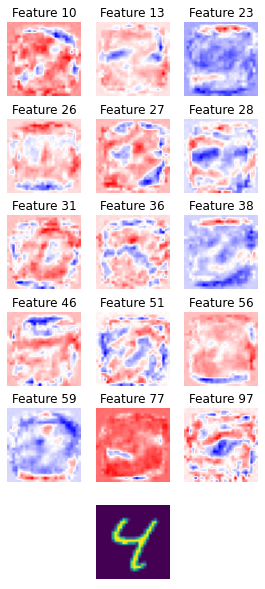

In [67]:
from matplotlib import cm
import math

rnd = lambda t: (1000*t).round() / 1000

img, label = testset[6]
print(label)
a_0 = model.layers[0](img.flatten(start_dim=1).to(device))
#print(a_0 > 0.5)
precs = model.layers[1].preconditions(a_0)[:,label,:].squeeze()
#print(precs)
best_pred = model.layers[1].preconditions(a_0)[:,label,:].squeeze().argmax()
#print(best_pred)
pred_mems = model.layers[1].fuzzy_m.value()[label, best_pred]
#print(pred_mems > 0.5)
print("satisfied", logic.conjoin(logic.implies(pred_mems > 0.5, a_0 > 0.5), dim=-1).item())
features = (pred_mems > 0.5).nonzero().squeeze()
print(features)

no_cols = 3
no_rows = math.ceil(len(features) / no_cols) + 1

fig, ax = plt.subplots(no_rows, no_cols)#len(features) + 1)
#fig.set_size_inches((len(features)+1)*1.5*1.2, 1.5)
fig.set_size_inches(no_cols*1.5, no_rows*1.5*1.15)

img_var = nn.Parameter(img, requires_grad=True)

for _ax in ax:
    for __ax in _ax:
        __ax.axis("off")

for idx, feature in enumerate(features):
    #print("gradding", feature.item())
    a_0_var = model.layers[0](img_var.flatten(start_dim=1).to(device))
    loss = -a_0_var[:,feature].sum()
    loss.backward()
    _ax = ax[idx // no_cols,idx % no_cols]
    _ax.imshow(img_var.grad.squeeze().detach().cpu().numpy(), cmap="bwr")
    _ax.set_title("Feature %s" % feature.item())
    img_var.grad = None
    
ax[no_rows - 1,no_cols // 2].imshow(img_var.squeeze().detach().cpu().numpy(), cmap="viridis")

In [71]:
reg_no_l2 = regimes[0]()
reg_l2 = regimes[1]()

def plot_regime(regime, metric, color, ax):
    
    try:

        regime.load_latest_models()
        regime.load_all_results()

        for i in range(len(regime.results)):
            if regime.results[i] is None:
                if i == 0:
                    return False
                break
            plt.plot(
                regime.results[i]['epoch'], 
                regime.results[i][metric],
                color=color,
                alpha=0.3
            )

        return True
    
    except:
        return False

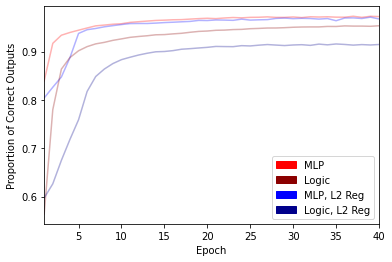

In [108]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots()

plot_regime(reg_no_l2, "correct-output", color="red", ax=ax)
plot_regime(reg_l2, "correct-output", color="blue", ax=ax)

plot_regime(reg_no_l2, "logic-correct-output", color="darkred", ax=ax)
plot_regime(reg_l2, "logic-correct-output", color="darkblue", ax=ax)

ax.set_xlim(1, 40)
ax.set_xlabel("Epoch")
ax.set_ylabel("Proportion of Correct Outputs")

lines = [
    ("red", "MLP"),
    ("darkred", "Logic"),
    ("blue", "MLP, L2 Reg"),
    ("darkblue", "Logic, L2 Reg"),
]
                    
ax.legend(handles=[mpatches.Patch(color=color, label=label) for color, label in lines])

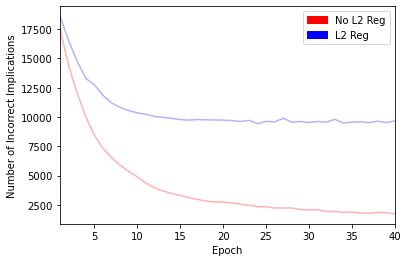

In [109]:
fig, ax = plt.subplots()

plot_regime(reg_no_l2, "unsatisfied", color="red", ax=ax)
plot_regime(reg_l2, "unsatisfied", color="blue", ax=ax)

ax.set_xlim(1, 40)
ax.set_xlabel("Epoch")
ax.set_ylabel("Number of Incorrect Implications")

lines = [
    ("red", "No L2 Reg"),
    ("blue", "L2 Reg"),
]
                    
ax.legend(handles=[mpatches.Patch(color=color, label=label) for color, label in lines])

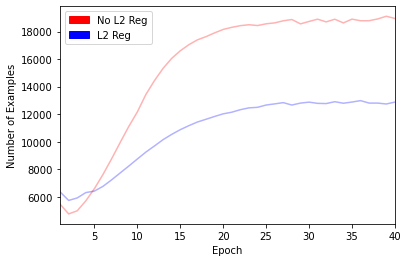

In [111]:
fig, ax = plt.subplots()

plot_regime(reg_no_l2, "examples", color="red", ax=ax)
plot_regime(reg_l2, "examples", color="blue", ax=ax)

ax.set_xlim(1, 40)
ax.set_xlabel("Epoch")
ax.set_ylabel("Number of Examples")

lines = [
    ("red", "No L2 Reg"),
    ("blue", "L2 Reg"),
]
                    
ax.legend(handles=[mpatches.Patch(color=color, label=label) for color, label in lines])

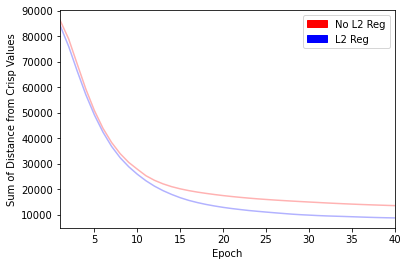

In [110]:
fig, ax = plt.subplots()

plot_regime(reg_no_l2, "crispness", color="red", ax=ax)
plot_regime(reg_l2, "crispness", color="blue", ax=ax)

ax.set_xlim(1, 40)
ax.set_xlabel("Epoch")
ax.set_ylabel("Sum of Distance from Crisp Values")

lines = [
    ("red", "No L2 Reg"),
    ("blue", "L2 Reg"),
]
                    
ax.legend(handles=[mpatches.Patch(color=color, label=label) for color, label in lines])

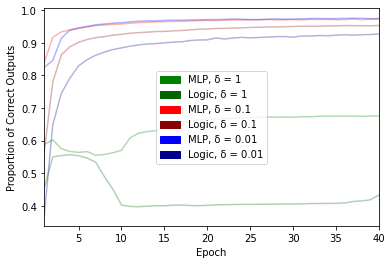

In [113]:
reg_d001 = regimes[2]()
reg_d1 = regimes[3]()

fig, ax = plt.subplots()

plot_regime(reg_d1, "correct-output", color="green", ax=ax)
plot_regime(reg_no_l2, "correct-output", color="red", ax=ax)
plot_regime(reg_d001, "correct-output", color="blue", ax=ax)
plot_regime(reg_d1, "logic-correct-output", color="darkgreen", ax=ax)
plot_regime(reg_no_l2, "logic-correct-output", color="darkred", ax=ax)
plot_regime(reg_d001, "logic-correct-output", color="darkblue", ax=ax)

ax.set_xlim(1, 40)
ax.set_xlabel("Epoch")
ax.set_ylabel("Proportion of Correct Outputs")

lines = [
    ("green", "MLP, δ = 1"),
    ("darkgreen", "Logic, δ = 1"),
    ("red", "MLP, δ = 0.1"),
    ("darkred", "Logic, δ = 0.1"),
    ("blue", "MLP, δ = 0.01"),
    ("darkblue", "Logic, δ = 0.01"),
]
                    
ax.legend(handles=[mpatches.Patch(color=color, label=label) for color, label in lines])

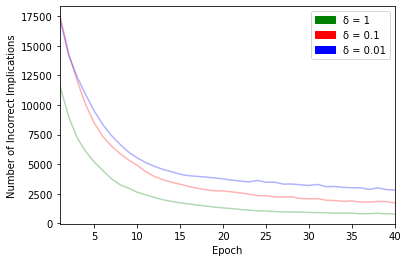

In [114]:
fig, ax = plt.subplots()

plot_regime(reg_d1, "unsatisfied", color="green", ax=ax)
plot_regime(reg_no_l2, "unsatisfied", color="red", ax=ax)
plot_regime(reg_d001, "unsatisfied", color="blue", ax=ax)

ax.set_xlim(1, 40)
ax.set_xlabel("Epoch")
ax.set_ylabel("Number of Incorrect Implications")

lines = [
    ("green", "δ = 1"),
    ("red", "δ = 0.1"),
    ("blue", "δ = 0.01"),
]
                    
ax.legend(handles=[mpatches.Patch(color=color, label=label) for color, label in lines])

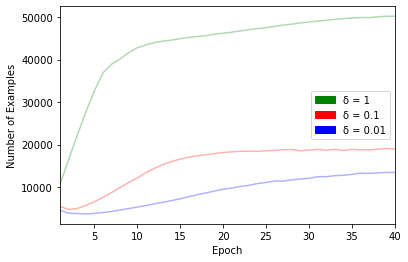

In [115]:
fig, ax = plt.subplots()

plot_regime(reg_d1, "examples", color="green", ax=ax)
plot_regime(reg_no_l2, "examples", color="red", ax=ax)
plot_regime(reg_d001, "examples", color="blue", ax=ax)

ax.set_xlim(1, 40)
ax.set_xlabel("Epoch")
ax.set_ylabel("Number of Examples")

lines = [
    ("green", "δ = 1"),
    ("red", "δ = 0.1"),
    ("blue", "δ = 0.01"),
]
                    
ax.legend(handles=[mpatches.Patch(color=color, label=label) for color, label in lines])

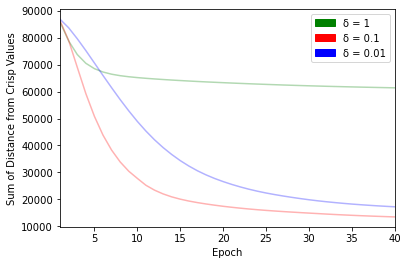

In [116]:
fig, ax = plt.subplots()

plot_regime(reg_d1, "crispness", color="green", ax=ax)
plot_regime(reg_no_l2, "crispness", color="red", ax=ax)
plot_regime(reg_d001, "crispness", color="blue", ax=ax)

ax.set_xlim(1, 40)
ax.set_xlabel("Epoch")
ax.set_ylabel("Sum of Distance from Crisp Values")
lines = [
    ("green", "δ = 1"),
    ("red", "δ = 0.1"),
    ("blue", "δ = 0.01"),
]
                    
ax.legend(handles=[mpatches.Patch(color=color, label=label) for color, label in lines])

In [ ]:
class MNISTAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 4),
            nn.Sigmoid(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(4, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 28*28),
            nn.LeakyReLU(),
        )
        
    def encode(self, input):
        return self.encoder(input)
    
    def decode(self, latent):
        decoded = self.decoder(latent)
        return decoded.reshape(*decoded.shape[:-1], 1, 28, 28)
    
    def forward(self, input):
        return self.decode(self.encode(input))

In [ ]:
ae_model = MNISTAutoEncoder().to(device)
no_ae_epochs = 30

In [ ]:
def train_ae():
    optim = torch.optim.Adam(ae_model.parameters(), lr=1e-3)

    losses = []
    for epoch_no in range(1, no_ae_epochs + 1):
        for imgs, _ in tqdm(trainloader, desc="Training Epoch %s" % epoch_no, leave=False):
            decoding = ae_model(imgs.to(device))
            loss = ((imgs.to(device) - decoding) ** 2).sum()
            losses.append(loss.item())

            optim.zero_grad()
            loss.backward()
            optim.step()
            
    return torch.tensor(losses)

train_ae()

In [ ]:
for imgs, _ in testloader:
    i=14
    img = imgs[i:i+1]
    decoding = ae_model(img.to(device))
    fig, ax = plt.subplots(2)
    ax[0].imshow(img.squeeze().cpu().numpy())
    ax[1].imshow(decoding.squeeze().detach().cpu().numpy())
    break

In [ ]:
from matplotlib import cm

snapshots = 5

for imgs, labels in tqdm(reg.testing_dataloader(1)):
    i = 21
    img = imgs[i:i+1,:]
    label = labels[i]
    img = nn.Parameter(imgs[i:i+1,:], requires_grad=True)
    a_0 = model.layers[0](img.flatten(start_dim=1).to(device))
    a_1 = model.layers[1](a_0)
    loss = -a_0[:,45].sum()
    img.grad = None
    loss.backward()
    fig, ax = plt.subplots(2 + snapshots)
    ax[0].imshow(-img.grad.reshape(28,28).detach().cpu().numpy(), cmap="bwr")
    ax[1].imshow(img.reshape(28,28).detach().cpu().numpy())
    print(a_1)
    #print(model.layers[1].fuzzy_m.value()[2,:,:] > 0.5)
    #print(a_0 > 0.9)
    features = (model.layers[1].fuzzy_m.value()[label,0,:]).unsqueeze(0)#torch.logical_and(model.layers[1].fuzzy_m.value()[label,0,:] > 0.5, a_0 > 0.95)
    print(features > 0.9)
    
    new_img = FuzzyParam((1, 4)).to(device)
    optim = torch.optim.Adam(new_img.parameters(), lr=1e-2)
    
    snapshot_imgs = []
    
    for i in tqdm(range(snapshots * 1000)):
        input = ae_model.decode(new_img.value())
        a_0 = model.layers[0](input.flatten(start_dim=1))
        c_1 = torch.zeros_like(a_0, device=a_0.device)
        c_1[features > 0.9] = -1
        a_1 = c_1 * a_0
        #a_1 = -model.logic.conjoin(model.logic.implies(features.detach(), a_0), dim=-1)
        loss = a_1.sum()

        if i % 500 == 0:
            print(loss)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if i % 1000 == 0:
            snapshot_imgs.append( ae_model.decode(new_img.value()).squeeze().detach().cpu())
    
    for idx, snap_img in enumerate(snapshot_imgs):
        ax[2 + idx].imshow(snap_img.numpy())
    
    break

In [ ]:
model(ae_model.decode(new_img.value()))

In [ ]:
fts= model.layers[1].fuzzy_m.value()[label,0,:]
torch.min(fts, 1 - fts).mean()